# Correlation analysis
Here we perform different correlation analyses between genes from our transcriptomics dataset and protein yield
- 1 - Correlation between genes and protein yield in the entire dataset
- 2 - Correlation between genes and protein yield within Cluster 3
- 3 - Correlation between genes and protein yield between Low and High producers

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import combine_pvalues
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define file paths
abundance_file = 'data/rnaseq_abundance.csv'
counts_file = 'data/rnaseq_counts.csv'
length_file = 'data/rnaseq_length.csv'

# Load data
abundance_data = pd.read_csv(abundance_file, index_col=0)
counts_data = pd.read_csv(counts_file, index_col=0)
length_data = pd.read_csv(length_file, index_col=0)

## Normalize the counts to TPMs
1 - Calculate RPK (Reads Per Kilobase): Divide the counts by the gene length (in kilobases).

3 - Calculate the Scaling Factor: Sum up the RPK values for each sample to get a total RPK value.

4 - Normalize to TPM: Divide each gene's RPK by the total RPK for the respective sample, then multiply by 

In [3]:
# Define a function to normalize counts to TPMs
def normalize_to_tpm(counts_df, lengths_df):
    # Step 1: Calculate RPK
    lengths_kb = lengths_df / 1000  # Convert lengths to kilobases
    rpk = counts_df.div(lengths_kb)

    # Step 2: Calculate scaling factors (sum of RPKs for each sample)
    scaling_factors = rpk.sum(axis=0)

    # Step 3: Normalize to TPM
    tpm = rpk.div(scaling_factors) * 1e6

    return tpm

# Perform normalization
tpm_data = normalize_to_tpm(counts_data, length_data)

## Load protein data and combine with rna_seq

In [4]:
# Load protein yield data
protein_yield_data = pd.read_csv('data/supplementary_data_1.csv')
# Load protein specific data
protein_specific_data = pd.read_excel('data/media-4.xlsx', sheet_name='all features')

# Ensure 'Total.purified.protein_stock1.stock2_microg' is float and fill NaN with 0
protein_yield_data['Total.purified.protein_stock1.stock2_microg'] = pd.to_numeric(
    protein_yield_data['Total.purified.protein_stock1.stock2_microg'], errors='coerce'
).fillna(0)

# Select relevant columns from the protein yield data
protein_yield = protein_yield_data[['sample_ID', 'genes', 'Total.purified.protein_stock1.stock2_microg', 'amount_microgram']]
# Select relevant columns from the protein specific data
aa_comp_c = protein_specific_data[['human_symbol', 'sequence_AA.comp_AA.Comp_C']]

# Merge both dfs
merged_df = protein_yield.merge(
    aa_comp_c,  # select only the relevant columns from aa_comp_C
    left_on='genes',       # the key column in protein_yield
    right_on='human_symbol',  # the key column in aa_comp_C
    how='left'             # left join ensures all protein_yield rows are kept
)


# Ensure sample_ID matches TPM column names
merged_df.set_index('sample_ID', inplace=True)

# Align TPM data with protein yield data
aligned_tpm_data = tpm_data.loc[:, merged_df.index]

# Combine the TPM data with protein yield data
combined_data = aligned_tpm_data.T.reset_index()  # Transpose to align samples and reset index
combined_data.set_index('sample_ID', inplace=True)
combined_data['Total_protein_microg'] = merged_df['Total.purified.protein_stock1.stock2_microg'].values
combined_data['Category'] = merged_df['amount_microgram'].values
combined_data['Comp_C'] = merged_df['sequence_AA.comp_AA.Comp_C'].values

In [5]:
# Define set of experimentally validated genes

# List of custom genes
custom_genes = ['Agpat4', 'LOC100750792', 'Nsd1', # Mina's
                'LOC100757909', 'Hspa8', 'Ern1', #Malm's
                'Pdia3', 'Uggt1', 'Rpn1'] # Giulia's

# Check which custom genes are present in the combined data columns
present_genes = [gene for gene in custom_genes if gene in combined_data.columns]
missing_genes = [gene for gene in custom_genes if gene not in combined_data.columns]

# Display results
print(f"Present genes: {present_genes}")
print(f"Missing genes: {missing_genes}")

Present genes: ['Agpat4', 'LOC100750792', 'Nsd1', 'LOC100757909', 'Hspa8', 'Ern1', 'Pdia3', 'Uggt1', 'Rpn1']
Missing genes: []


## 1 - Correlation between genes and protein yield in the entire dataset

In [6]:
# Filter out genes with constant values or missing data
filtered_data = combined_data.dropna(axis=1).loc[:, combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation       P-Value
0  LOC100755269     0.598517  1.192523e-10
1         Stx19     0.598517  1.192523e-10
2        Gimap6     0.598517  1.192523e-10
3        Mgat5b     0.488340  4.479329e-07
4         Cldn2     0.407018  3.865814e-05
5  LOC100751635     0.404135  4.437505e-05
6          Zbbx     0.388255  9.276676e-05
7          Cdh2     0.369094  2.151300e-04
8  LOC100767578     0.368608  2.196256e-04
9          Ryr2     0.358432  3.360318e-04

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
20063          Fn3k    -0.256537  0.011636
20064  LOC103161115    -0.257307  0.011379
20065  LOC103164406    -0.260528  0.010358
20066  LOC103159353    -0.262427  0.009794
20067       Ankrd23    -0.263505  0.009486
20068  LOC103162644    -0.287149  0.004559
20069  LOC107980021    -0.295095  0.003514
20070         Setd9    -0.304265  0.002579
20071  LOC100773247    -0

### 1.1 Barplot top 10 negatively and positively correlated genes

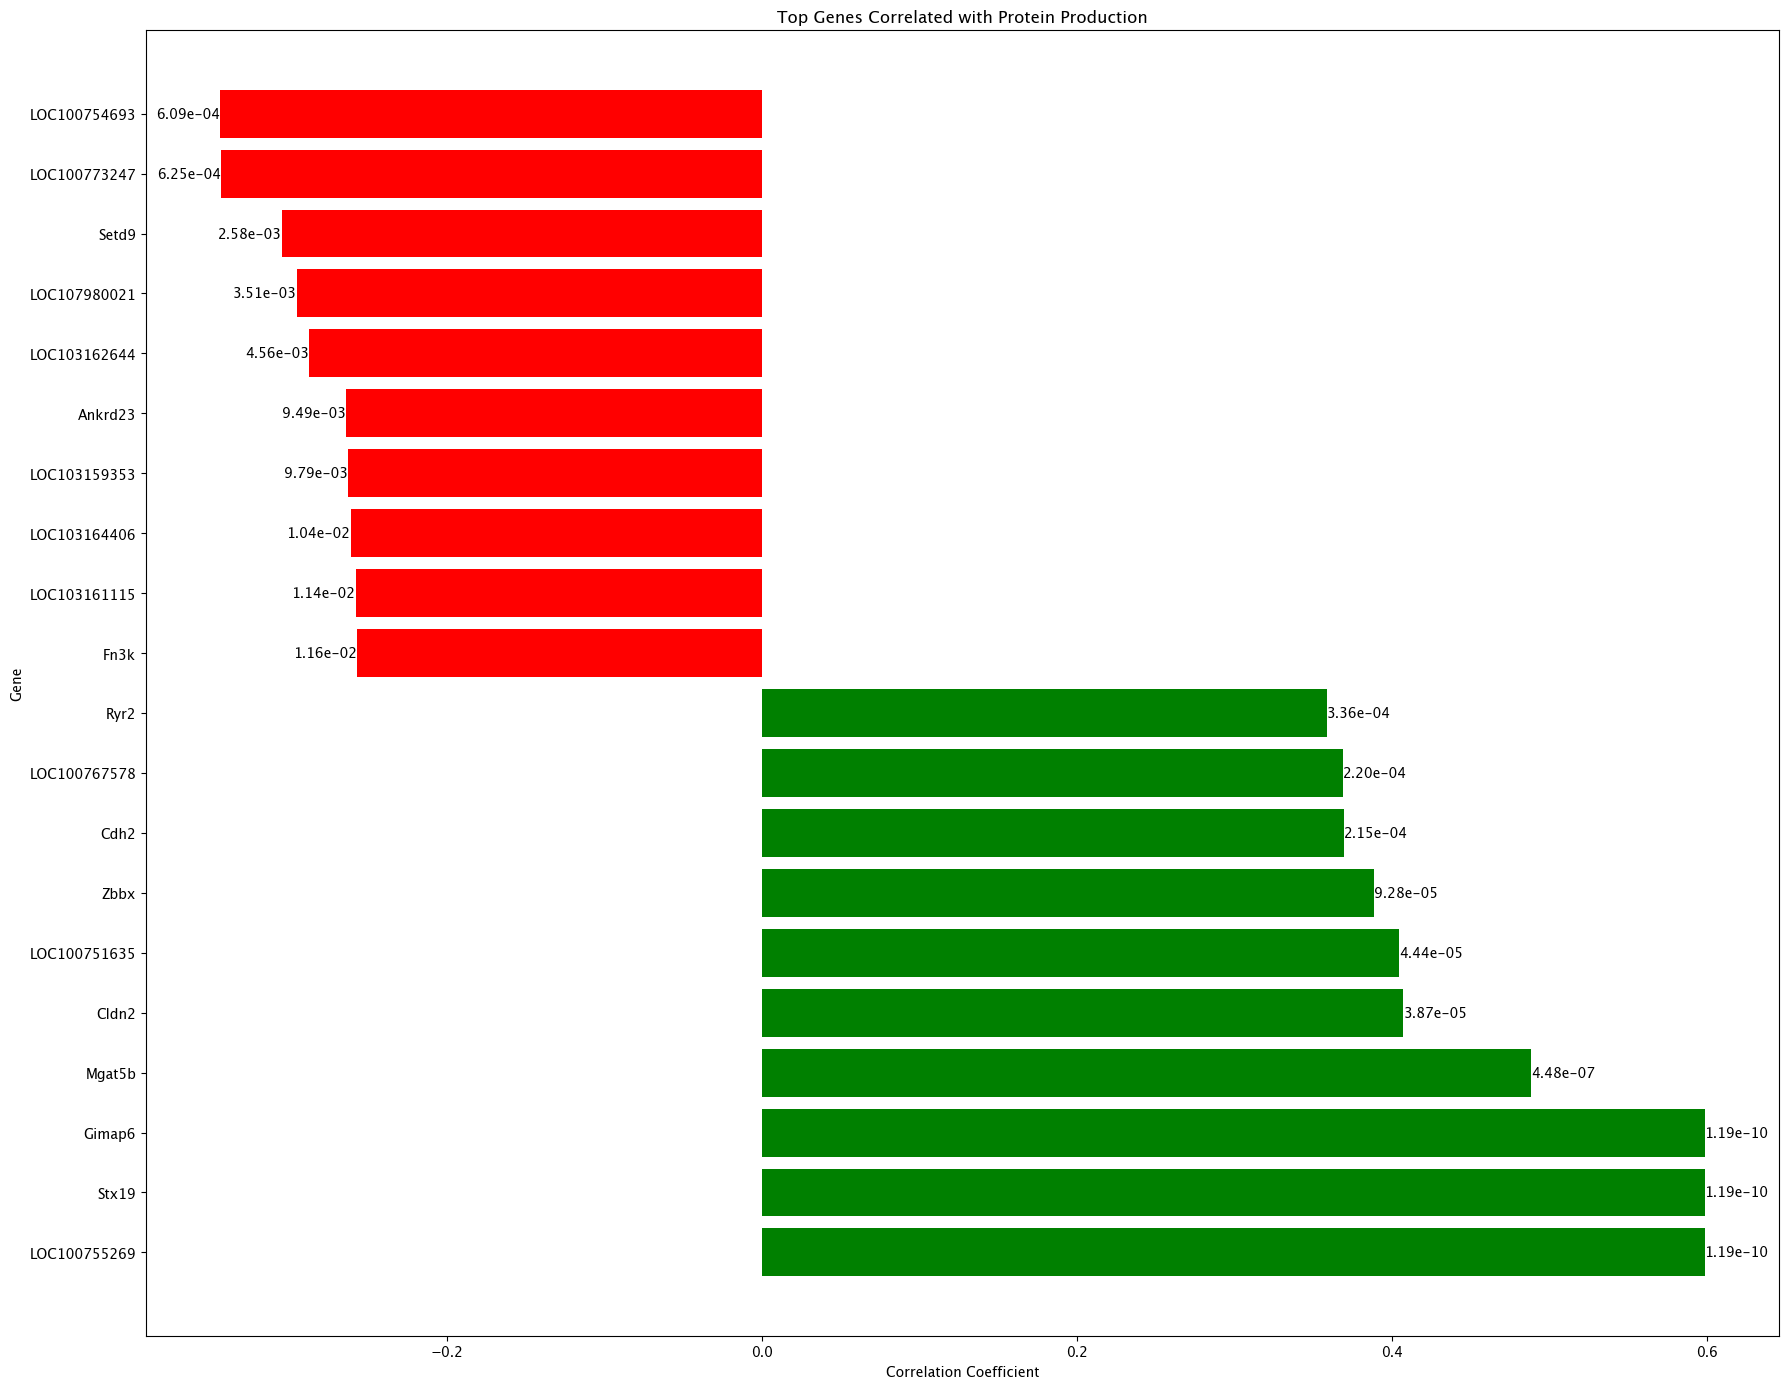

In [7]:
# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([correlation_df.head(10), correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()


### 1.2 Barplot experimentally tested genes

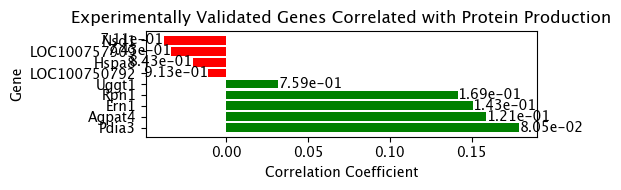

In [8]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 2))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

## 2 - Correlation between genes and protein yield within Cluster 3

In [9]:
# Load cluster assingment dataset
sec_clusters = pd.read_excel('data/Secretome_clusterAssignment.xlsx')
# Create dictionary for mapping
sample_cluster_dict = dict(zip(sec_clusters['sample_ID'], sec_clusters['cluster']))

In [10]:
# Filter dataset to subset only cluster 3

# Map the cluster values to the sample_ID column
filtered_data['Cluster'] = filtered_data.index.map(sample_cluster_dict).fillna(-1).astype(int)

# Filter for samples in cluster 3
cluster_3_data = filtered_data[filtered_data['Cluster'] == 3].drop(columns=['Cluster'])

In [11]:
# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in cluster_3_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = cluster_3_data[gene]
    protein_production = cluster_3_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_3882/480338098.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(gene_expression, protein_production)


### 2.1 Barplot top 10 negatively and positively correlated genes

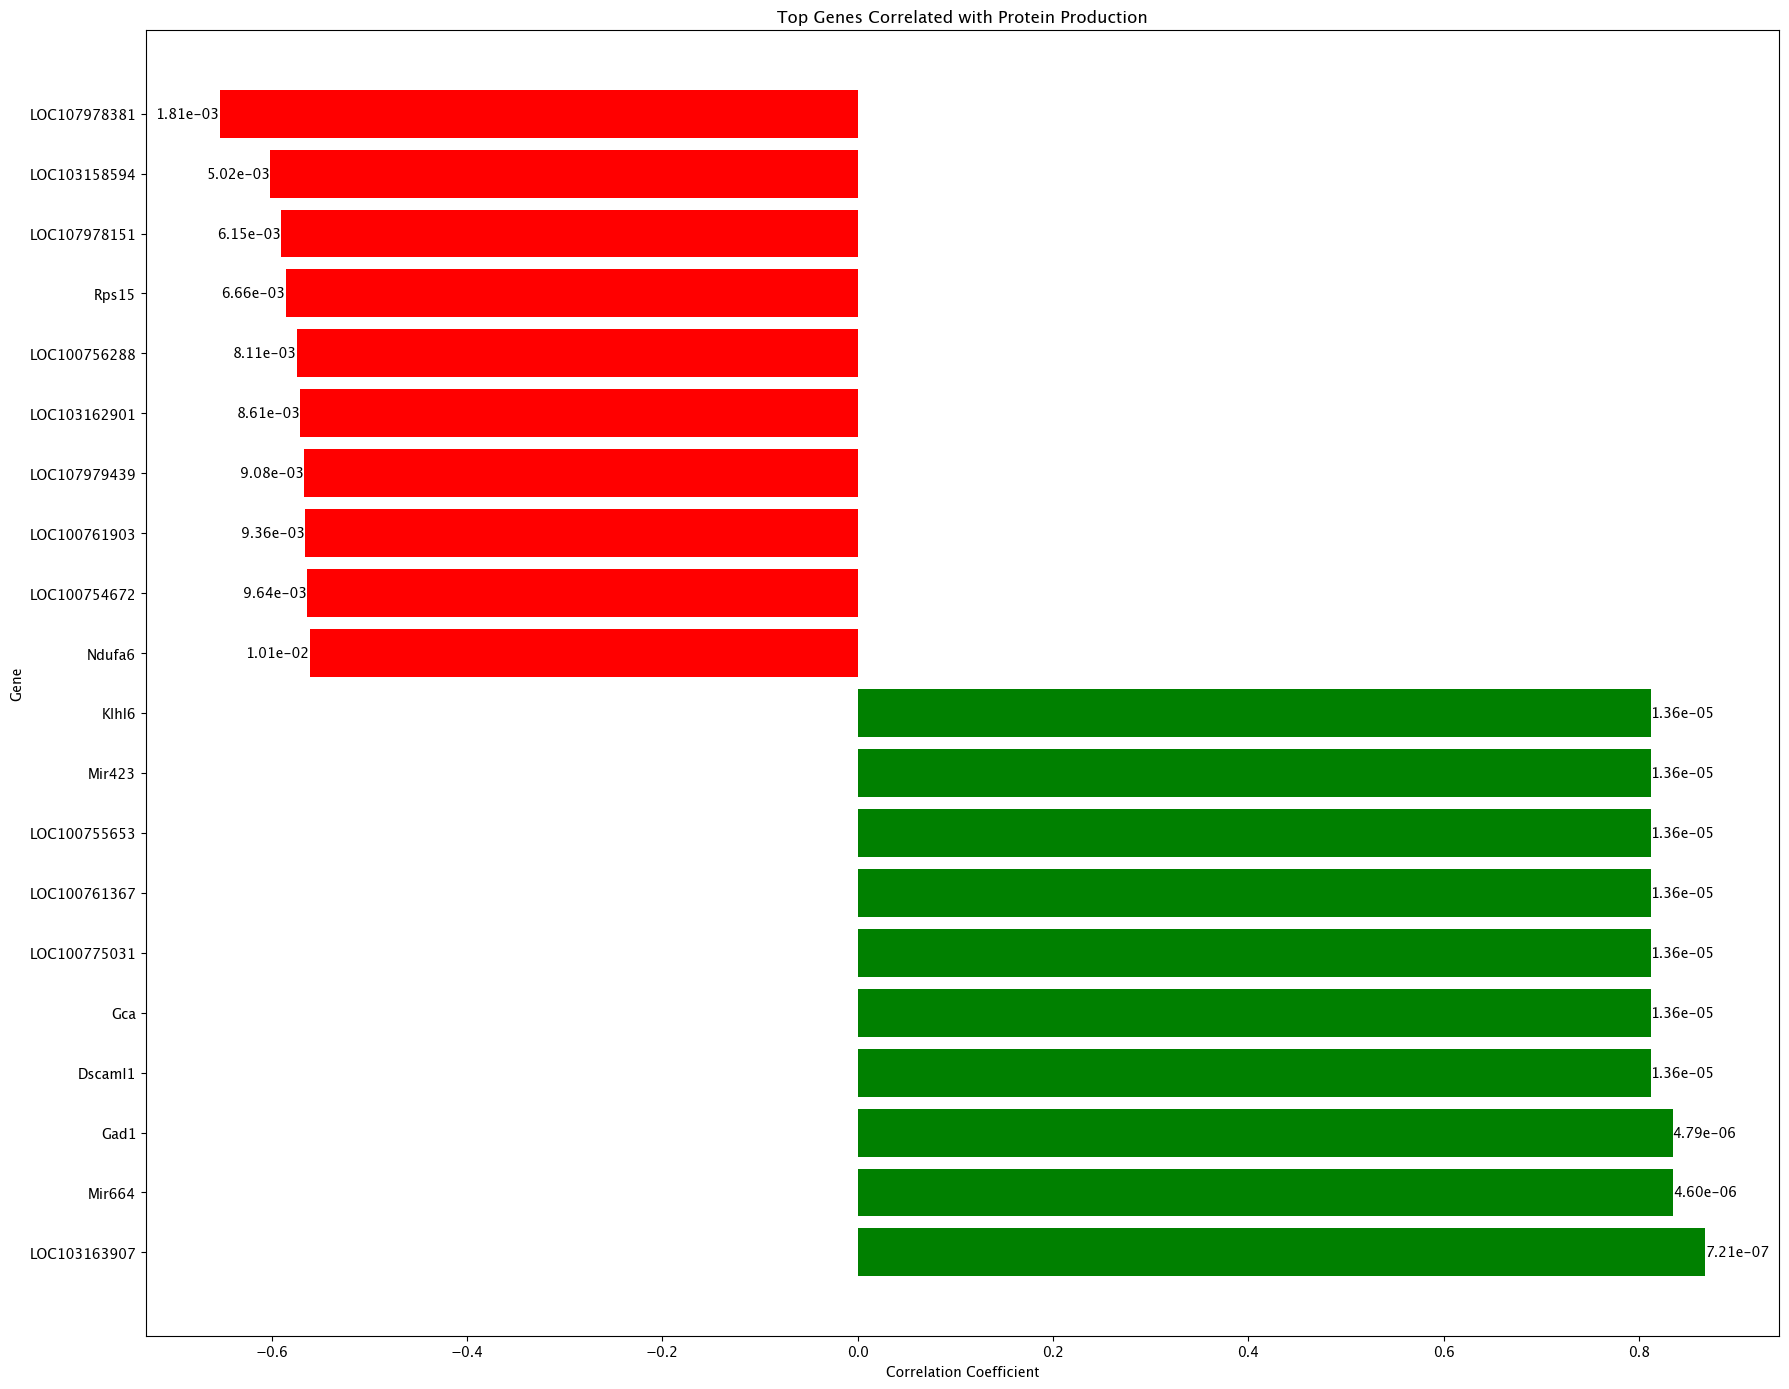

In [12]:
filtered_correlation_df = correlation_df[
    correlation_df['Correlation'].notnull() & correlation_df['P-Value'].notnull()
]

# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([filtered_correlation_df.head(10), filtered_correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 2.2 Barplot experimentally tested genes

posx and posy should be finite values
posx and posy should be finite values


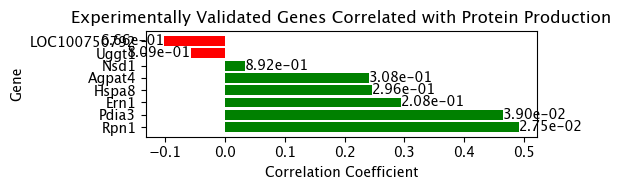

In [13]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 2))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

## 3 - Correlation between genes and protein yield between Low and High producers

In [14]:
# Filter combined_data based on the 'Category' column
highlow_combined_data = combined_data[
    combined_data['Category'].isin(['highest amount', 'no amount'])
]

# Drop the 'Category' column
highlow_combined_data = highlow_combined_data.drop(columns=['Category'])

In [15]:
# Filter out genes with constant values or missing data
filtered_data = highlow_combined_data.dropna(axis=1).loc[:, highlow_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Adjust for one-sided hypothesis
    if corr > 0:
        p_value = p_value / 2  # One-sided for positive correlation
    else:
        p_value = 1 - (p_value / 2)  # One-sided for negative correlation

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation   P-Value
0  LOC107978826     0.806997  0.000015
1          Ano6     0.768687  0.000060
2  LOC100772093     0.764894  0.000068
3          Il20     0.758828  0.000083
4        Hivep1     0.757982  0.000085
5  LOC100761556     0.757557  0.000086
6  LOC107980087     0.756270  0.000090
7          Fggy     0.753414  0.000098
8         Peak1     0.747937  0.000116
9         Prkcd     0.743952  0.000130

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
18504        Smim20    -0.701954  0.999596
18505         Rps26    -0.702755  0.999604
18506         Crocc    -0.705790  0.999633
18507  LOC103164274    -0.706443  0.999639
18508  LOC107980326    -0.711871  0.999685
18509         Nr2f6    -0.715685  0.999715
18510  LOC103158789    -0.719290  0.999741
18511        Gtpbp6    -0.723480  0.999768
18512         Cxxc5    -0.725170  0.999779
18513  LOC100756957    -0.

### 3.1 Barplot top 10 negatively and positively correlated genes

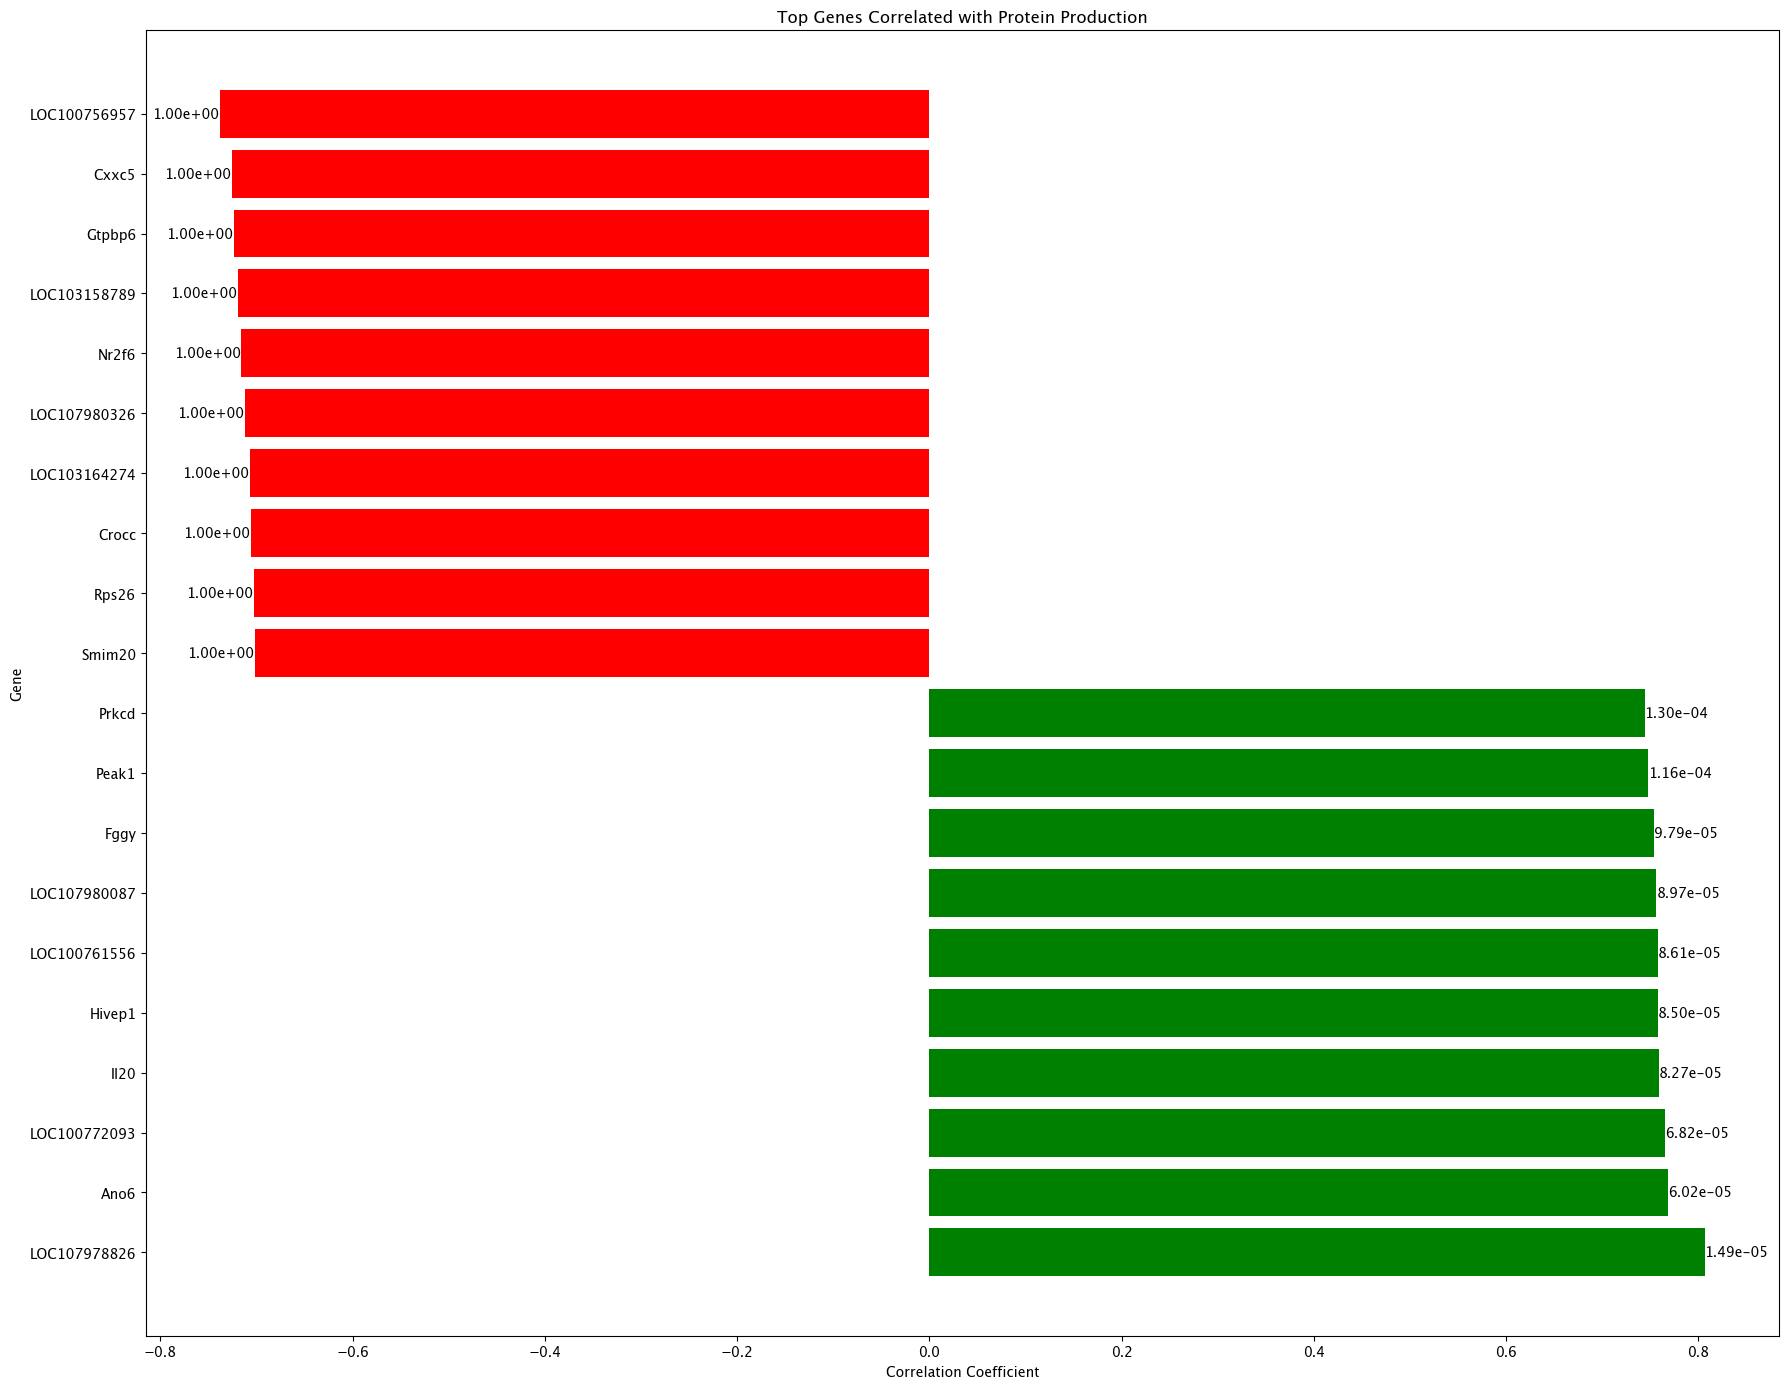

In [16]:
filtered_correlation_df = correlation_df[
    correlation_df['Correlation'].notnull() & correlation_df['P-Value'].notnull()
]

# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([filtered_correlation_df.head(10), filtered_correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 3.2 Barplot experimentally tested genes

In [32]:
# -------------------------------------------
# 1) RENAME “LOC” GENES TO STANDARD SYMBOLS
# -------------------------------------------
rename_dict = {
    'LOC100757909': 'Eif2ak2',  # Malm’s
    'LOC100750792': 'Ephx1'     # Mina’s
}

# -------------------------------------------
# 2) CREATE A PAPER/GROUP MAPPING & COLOR MAP
# -------------------------------------------
paper_mapping = {
    'Mina':    ['Agpat4', 'Ephx1',  'Nsd1'],
    'Malm':    ['Eif2ak2', 'Hspa8', 'Ern1'],
    'Giulia':  ['Pdia3',   'Uggt1', 'Rpn1']
}

paper_color_dict = {
    'Mina':   'royalblue',
    'Malm':   'darkorange',
    'Giulia': 'forestgreen'
}

def get_paper(gene):
    """Return the paper/group name given a gene."""
    for paper, gene_list in paper_mapping.items():
        if gene in gene_list:
            return paper
    return 'Unknown'

# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)
# Rename LOC genes for visualization
selected_genes['Gene'] = selected_genes['Gene'].replace(rename_dict)
# Add a “Paper” column
selected_genes['Paper'] = selected_genes['Gene'].apply(get_paper)

# Define custom order for the papers
paper_order = {'Mina': 1, 'Malm': 2, 'Giulia': 3}

# Create a new column for sorting
selected_genes['PaperOrder'] = selected_genes['Paper'].map(paper_order)

# Mask gene names for unpublished studies (Giulia and Mina)
unpublished_mask = selected_genes['Paper'].isin(['Mina', 'Giulia'])
counter = 1
for idx in selected_genes[unpublished_mask].index:
    selected_genes.loc[idx, 'Gene'] = f'Gene {counter}'
    counter += 1

# Sort by Paper → then optionally by the original custom_genes order
# or just keep the order they appear in paper_mapping
selected_genes = selected_genes.sort_values(by='PaperOrder', ascending=True)
selected_genes.reset_index(drop=True, inplace=True)

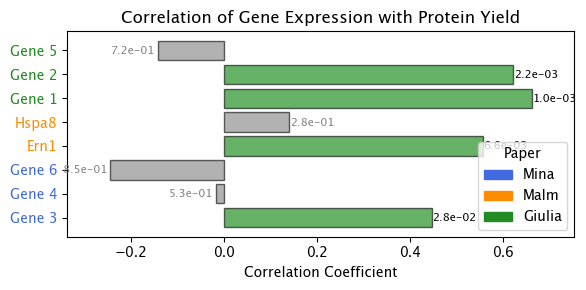

In [34]:
# Define significance threshold
significance_threshold = 0.05

# Determine bar colors based on significance
bar_colors = [
    'green' if (c > 0 and p < significance_threshold) else
    'red' if (c < 0 and p < significance_threshold) else
    'gray'  # Gray out non-significant genes
    for c, p in zip(selected_genes['Correlation'], selected_genes['P-Value'])
]

fig, ax = plt.subplots(figsize=(6, 3))

# Create bars with adjusted colors
bars = ax.barh(
    selected_genes['Gene'],
    selected_genes['Correlation'],
    color=bar_colors,
    edgecolor='black',  # Outline color
    linewidth=1.0,      # Outline thickness
    alpha=0.6           # Dim fill color
)

# Annotate each bar with p-value, graying out non-significant values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    xval = bar.get_width()
    ymid = bar.get_y() + bar.get_height() / 2
    
    # Offset positioning
    offset = 0.0006 if xval > 0 else -0.005
    ha = 'left' if xval > 0 else 'right'
    
    # Change annotation color to gray if non-significant
    text_color = 'black' if p_value < significance_threshold else 'gray'
    
    ax.text(
        xval + offset,
        ymid,
        f'{p_value:.1e}',
        va='center',
        ha=ha,
        fontsize=8,
        fontweight='bold',
        color=text_color
    )

# Keep y-axis tick labels in their original colors
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    gene_name = label.get_text()
    paper_name = selected_genes.loc[selected_genes['Gene'] == gene_name, 'Paper'].values[0]
    label.set_color(paper_color_dict[paper_name])  # Maintain original color

# Create a legend for the paper colors only
legend_patches = [
    mpatches.Patch(color=color, label=paper)
    for paper, color in paper_color_dict.items()
]
ax.legend(handles=legend_patches, title='Paper', loc='lower right')

# --- Adjust X-Axis Limits to Avoid Overhang ---
min_corr = selected_genes['Correlation'].min()
max_corr = selected_genes['Correlation'].max()
padding = 0.1 * (max_corr - min_corr if max_corr != min_corr else 1)
ax.set_xlim(min_corr - padding, max_corr + padding)

# Add title and x-axis label
ax.set_title('Correlation of Gene Expression with Protein Yield', fontsize=12, fontweight='bold')
ax.set_xlabel('Correlation Coefficient', fontsize=10)

plt.savefig('results/Corr_exp_genes_protein_yield.svg', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


### 3.3 p-value for overlap
The goal of calculating the p-value for overlap is to determine whether the observed overlap between genes that were experimentally validated to increase productivity and genes that showed a positive correlation with protein titer is statistically significant or if it could have happened by random chance.

In simpler terms, we are asking:
"If we randomly selected 8 genes from the dataset, how likely would we observe 4 (or more) of them being positively correlated with titer just by chance?"

In [19]:
# Extract the total number of genes analyzed
total_genes = len(correlation_df)

# Define positively correlated genes: those with positive correlation and significant p-value
positively_correlated_genes = correlation_df[
    (correlation_df['Correlation'] > 0) & (correlation_df['P-Value'] < 0.05)
]
num_positively_correlated = len(positively_correlated_genes)

# Define negatively correlated genes: those with negative correlation and significant p-value
negatively_correlated_genes = correlation_df[
    (correlation_df['Correlation'] < 0) & (correlation_df['P-Value'] < 0.05)
]
num_negatively_correlated = len(negatively_correlated_genes)

# Define the 8 genes tested in follow-up studies (assuming they are present in correlation_df)
tested_genes = ['Agpat4', 'LOC100750792', 'Nsd1', # Mina's
                'LOC100757909', 'Hspa8', 'Ern1', #Malm's
                'Pdia3', 'Uggt1', 'Rpn1'] # Giulia's

# Filter tested genes from correlation_df
tested_genes_df = correlation_df[correlation_df['Gene'].isin(tested_genes)]

# Count how many tested genes are positively correlated
tested_positively_correlated = tested_genes_df[
    (tested_genes_df['Correlation'] > 0) & (tested_genes_df['P-Value'] < 0.05)
]
num_tested_positively_correlated = len(tested_positively_correlated)

# Count how many tested genes are negatively correlated
tested_negatively_correlated = tested_genes_df[
    (tested_genes_df['Correlation'] < 0) & (tested_genes_df['P-Value'] < 0.05)
]
num_tested_negatively_correlated = len(tested_negatively_correlated)

# Construct contingency table for Fisher's exact test
table = [
    [num_tested_positively_correlated, len(tested_genes) - num_tested_positively_correlated],  # Tested genes
    [num_positively_correlated - num_tested_positively_correlated, total_genes - num_positively_correlated]
]

# Perform Fisher's exact test
odds_ratio, p_value = stats.fisher_exact(table, alternative='greater')

p_value

0.15791736158393796

A high p-value (e.g., 0.16 in this case) suggests that the overlap could have happened by chance, meaning there is no strong statistical evidence that the tested genes were more likely to be positively correlated than random genes from the dataset.

## 4 - Ox Stress Genes correlation between High and Failed producers

In [20]:
# Filter combined_data based on the 'Category' column
highno_combined_data = combined_data[
    combined_data['Category'].isin(['highest amount', 'no amount'])
]

# Drop the 'Category' column
highno_combined_data = highno_combined_data.drop(columns=['Category'])

# Oxidative stress genes

ox_genes = ['Keap1', 'Trex1', 'Endog', 'Fancc', 'Gpx1', 'Gskip', 'LOC100754168', 'Zfand1', 'Hif1a',
            'Gba', 'Slc7a11','Bcl2', 'Slc11a2']

### 4.1 Correlation with protein yield

In [21]:
# Filter out genes with constant values or missing data
filtered_data = highno_combined_data.dropna(axis=1).loc[:, highno_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df_protein = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df_protein.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df_protein.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df_protein.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation   P-Value
0  LOC107978826     0.806997  0.000030
1          Ano6     0.768687  0.000120
2  LOC100772093     0.764894  0.000136
3          Il20     0.758828  0.000165
4        Hivep1     0.757982  0.000170
5  LOC100761556     0.757557  0.000172
6  LOC107980087     0.756270  0.000179
7          Fggy     0.753414  0.000196
8         Peak1     0.747937  0.000231
9         Prkcd     0.743952  0.000260

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
18504        Smim20    -0.701954  0.000808
18505         Rps26    -0.702755  0.000792
18506         Crocc    -0.705790  0.000734
18507  LOC103164274    -0.706443  0.000722
18508  LOC107980326    -0.711871  0.000629
18509         Nr2f6    -0.715685  0.000570
18510  LOC103158789    -0.719290  0.000518
18511        Gtpbp6    -0.723480  0.000464
18512         Cxxc5    -0.725170  0.000443
18513  LOC100756957    -0.

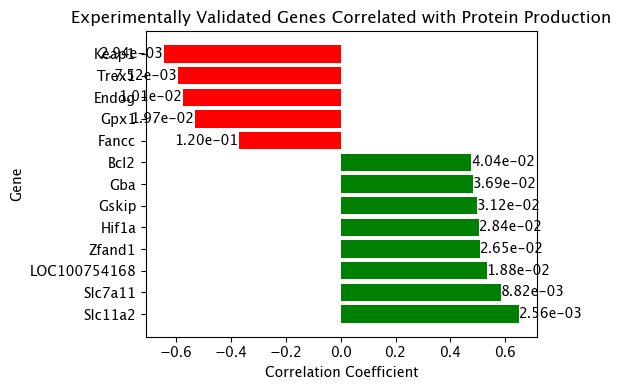

In [22]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df_protein[correlation_df_protein['Gene'].isin(ox_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 4))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 4.2 Correlation with AA comp Cisteine

In [23]:
# Filter out genes with constant values or missing data
filtered_data = highno_combined_data.dropna(axis=0).loc[:, highno_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    aa_comp_c = filtered_data['Comp_C']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, aa_comp_c)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df_cysteine = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df_cysteine.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Cisteine Composition:")
print(correlation_df_cysteine.head(10))
print('')
print("Top Genes Negatively Correlated with Cisteine Composition:")
print(correlation_df_cysteine.tail(10))

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_3882/2986260925.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(gene_expression, aa_comp_c)


Top Genes Positively Correlated with Cisteine Composition:
           Gene  Correlation   P-Value
0           Sln     0.816438  0.000064
1  LOC107977904     0.807005  0.000090
2       Slc6a19     0.775669  0.000253
3  LOC100753988     0.774842  0.000259
4  LOC100759428     0.768196  0.000316
5  LOC107979984     0.768196  0.000316
6  LOC100773501     0.744668  0.000605
7  LOC107980195     0.739581  0.000691
8        Spock2     0.735587  0.000764
9  LOC100761288     0.735555  0.000765

Top Genes Negatively Correlated with Cisteine Composition:
             Gene  Correlation  P-Value
18505     Spata2l          NaN      NaN
18506  Spindlin-2          NaN      NaN
18507  St6galnac1          NaN      NaN
18508      Stard8          NaN      NaN
18509     Sult6b1          NaN      NaN
18510        Theg          NaN      NaN
18511        Tsks          NaN      NaN
18512       Ttll8          NaN      NaN
18513        Xkr7          NaN      NaN
18514      Znf275          NaN      NaN


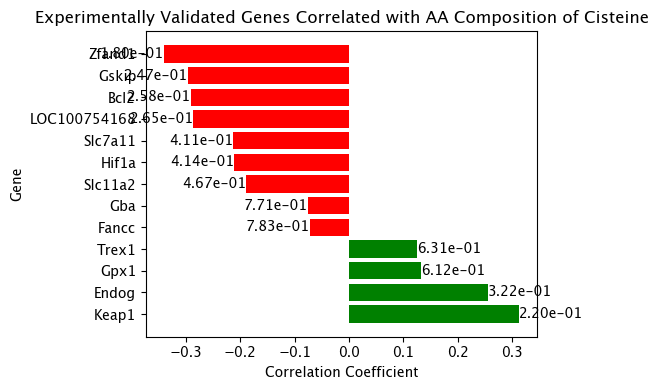

In [24]:
# Oxidative stress genes

ox_genes = ['Keap1', 'Trex1', 'Endog', 'Fancc', 'Gpx1', 'Gskip', 'LOC100754168', 'Zfand1', 'Hif1a',
            'Gba', 'Slc7a11','Bcl2', 'Slc11a2']

# LOC100754168: Slc25a24

# Filter correlation_df for the custom genes only
selected_genes = correlation_df_cysteine[correlation_df_cysteine['Gene'].isin(ox_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 4))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with AA Composition of Cisteine')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 4.3 Correlation with both parameters

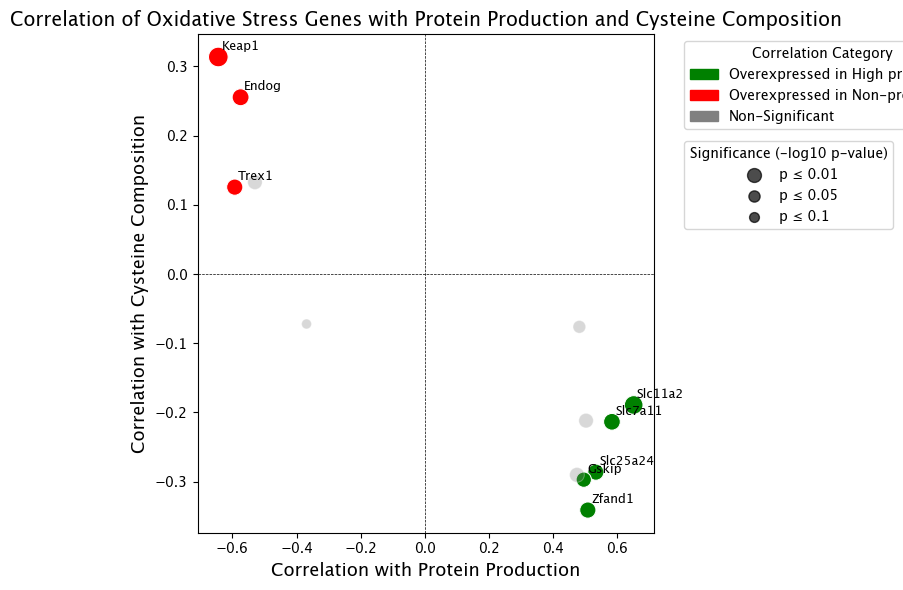

In [25]:
# Define significance threshold
p_threshold = 0.05

# Merge the two correlation DataFrames on the 'Gene' column
combined_corr_df = pd.merge(
    correlation_df_protein[['Gene', 'Correlation', 'P-Value']].rename(columns={'Correlation': 'Correlation_Protein', 'P-Value': 'P-Value_Protein'}),
    correlation_df_cysteine[['Gene', 'Correlation', 'P-Value']].rename(columns={'Correlation': 'Correlation_Cysteine', 'P-Value': 'P-Value_Cysteine'}),
    on='Gene'
)

# Filter for oxidative stress genes
combined_corr_df = combined_corr_df[combined_corr_df['Gene'].isin(ox_genes)]
combined_corr_df['Gene'] = combined_corr_df['Gene'].replace('LOC100754168', 'Slc25a24')

# Apply Fisher's combined probability test to merge p-values
combined_corr_df['Combined_pValue'] = combined_corr_df.apply(
    lambda row: combine_pvalues([row['P-Value_Protein'], row['P-Value_Cysteine']], method='fisher')[1], axis=1
)

# Convert to -log10 scale for visualization
combined_corr_df['-log10(Combined_pValue)'] = -np.log10(combined_corr_df['Combined_pValue'])

# Categorize genes based on significance
combined_corr_df['Significance'] = combined_corr_df['Combined_pValue'] < p_threshold

# Define colors: Significant genes stay green/red, non-significant genes are gray
colors = combined_corr_df.apply(lambda row: 'gray' if not row['Significance'] else 
                                ('green' if row['Correlation_Protein'] > 0 else 'red'), axis=1)

# Define alpha (transparency): Non-significant genes are more transparent
alphas = combined_corr_df['Significance'].apply(lambda x: 1.0 if x else 0.3)

# Create the scatter plot using the combined p-value
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=combined_corr_df,
    x='Correlation_Protein',
    y='Correlation_Cysteine',
    hue=colors,
    palette={'green': 'green', 'red': 'red', 'gray': 'gray'},  # Explicit color mapping
    size='-log10(Combined_pValue)',  # Use p-value size mapping
    sizes=(50, 200),  # Adjust size range
    alpha=alphas,  # Apply transparency effect
    legend=False  # Hide automatic legend for colors (we'll add a custom one)
)

# Add gene names as annotations *only for significant genes*
for i, row in combined_corr_df.iterrows():
    if row['Significance']:  # Only label significant genes
        plt.text(
            row['Correlation_Protein'] + 0.01,  # Offset for better visibility
            row['Correlation_Cysteine'] + 0.01,
            row['Gene'],
            fontsize=9,
            ha='left'
        )

# Add labels and title
plt.xlabel('Correlation with Protein Production', fontsize=13)
plt.ylabel('Correlation with Cysteine Composition', fontsize=13)
plt.title('Correlation of Oxidative Stress Genes with Protein Production and Cysteine Composition', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add horizontal line at y=0
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Add vertical line at x=0

# ----- Custom Legend for Colors -----
legend_patches = [
    mpatches.Patch(color='green', label='Overexpressed in High producers'),
    mpatches.Patch(color='red', label='Overexpressed in Non-producers'),
    mpatches.Patch(color='gray', label='Non-Significant')
]
color_legend = plt.legend(handles=legend_patches, title='Correlation Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# ----- Custom Legend for P-value Sizes -----
size_legend_labels = [0.01, 0.05, 0.1]  # Example p-values to show
size_legend = [plt.scatter([], [], s=-np.log10(p) * 50, color='black', alpha=0.7) for p in size_legend_labels]

plt.legend(
    size_legend, 
    [f'p ≤ {p}' for p in size_legend_labels],  # Change "=" to "≤"
    title='Significance (-log10 p-value)',
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left'
)

# Re-add color legend after p-value legend
plt.gca().add_artist(color_legend)

# Save the plot
plt.savefig('results/Corr_oxi_stress_genes_cysteinevsprotyield_combinedP_gray.svg', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
